In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
from typing import Callable, List
import numpy as np
from jax import random
import matplotlib.pyplot as plt
import equinox as eqx
import optax
import scipy
from tqdm.autonotebook import tqdm
from models.fno_model_2d import FNO2d

/var/folders/dj/9l55bm1s047crb4scq4r44vh0000gn/T/ipykernel_80146/938368935.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
data= jnp.load("create_data/training_data_2d.npy")

In [3]:
data_in = data[:10000, :3, :, :]   #  remove the 1000 in both lines to use all data
data_out = data[:10000, 3, :, :]
data_out = data_out[:, jnp.newaxis, :, :]
#N_split = int(2/3 * len(data_in))


train_in, test_in = data_in[:-100], data_in[-100:]   # can also put in N_split but than need to adjust calculation of val loss (currently on whole testdataset, and this than blocks storage and computation capacity for other operations, maybe fine on HPC)
train_out, test_out = data_out[:-100], data_out[-100:]

# maybe normalize the data?
# maybe train on 1D data (or only few steps in one direction) (choose one exact x-value (or a few) in training data to see if network works)

In [4]:
def dataloader(
    key,
    dataset_x,
    dataset_y,
    batch_size,
):
    n_samples = dataset_x.shape[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        yield dataset_x[batch_indices], dataset_y[batch_indices]

In [5]:
fno2d = FNO2d(
    3,
    1,
    16,
    16,
    32,
    0.2,
    jax.nn.relu,
    key=jax.random.PRNGKey(0),
)

# maybe change number of blocks also

# optimal so far: 16,16 for modes; 32 for width; 0.2 for dropout  (# 0.0069615683)

# new optimal: 16,16 for modes; 32 for width; 0.2 for dropout but more training data (0.0061003845)

In [6]:
def loss_fn(model, x, y, key, deterministic=False):
    y_pred = jax.vmap(model, in_axes=(0, None, None))(x, key, deterministic)
    loss = jnp.mean(jnp.square(y_pred - y))
    return loss

# add physics loss?

lr_schedule = optax.linear_schedule(init_value=3e-4, end_value=1e-5, transition_steps=1000)
# maybe try without schedule one time

optimizer = optax.adamw(learning_rate=lr_schedule, weight_decay=1e-4)    # added weight decay (before optax.adam was used)
opt_state = optimizer.init(eqx.filter(fno2d, eqx.is_array))

@eqx.filter_jit   #was bedeutet das? -> reinmachen wieder
def make_step(model, state, key, x, y):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x, y, key, deterministic=False)
    val_loss = loss_fn(model, test_in, test_out, key, deterministic=True)
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss, val_loss

loss_history = []
val_loss_history = []

shuffle_key = jax.random.PRNGKey(10)
for epoch in tqdm(range(50)):
    shuffle_key, subkey = jax.random.split(shuffle_key)
    for (batch_x, batch_y) in dataloader(
        subkey,
        train_in,   # maybe check if reduced resolution also works
        train_out,
        batch_size=64,  # higher or lower? - maybe even higher when number of parameters is higher
    ):
        shuffle_key, subkey = jax.random.split(shuffle_key)
        fno2d, opt_state, loss, val_loss = make_step(fno2d, opt_state, subkey, batch_x, batch_y) 
        loss_history.append(loss)
        val_loss_history.append(val_loss)
        print(val_loss)

# if results aren't good check again, that dropout masks changes in every layer and in every epoch

  0%|          | 0/50 [00:00<?, ?it/s]

0.22798204
0.29174688
0.37372243
0.42924953
0.48413384
0.53070056
0.5273116
0.48731038
0.43769148
0.38577378
0.33686647
0.2863464
0.24240041
0.20413788
0.17160618
0.14637327
0.12603779
0.10909735
0.096913956
0.08854119
0.08175346
0.07623671
0.07197869
0.06889539
0.06751041
0.06626868
0.06489896
0.064054474
0.06354077
0.06310104
0.062438708
0.061949786
0.061567925
0.061347444
0.061199296
0.061035674
0.060815338
0.06063493
0.06037285
0.060155623
0.060007647
0.059877977
0.059778057
0.059719175
0.059710924
0.05973094
0.059729017
0.05971066
0.05970328
0.059680086
0.059607066
0.059536
0.059480075
0.059427332
0.059405494
0.059372514
0.05934789
0.059307713
0.05929293
0.059255958
0.05917357
0.05910854
0.059047304
0.058988146
0.058930624
0.058834516
0.058743697
0.058640253
0.058544725
0.058484424
0.058482945
0.058467094
0.05850226
0.058576517
0.05862127
0.058631472
0.058609895
0.058653384
0.058656856
0.058620617
0.058600612
0.05857441
0.058528285
0.05841255
0.058287345
0.058125954
0.05800136
0.0

In [7]:
# maybe add lr schedule?
#lr_schedule = optax.linear_schedule(
#    init_value=1e-3,  
#    end_value=1e-5,   
#    transition_steps=1000  
#)

# old optimizer:
#optimizer = optax.adamw(learning_rate=lr_schedule, weight_decay=1e-4) 

0.0061003845


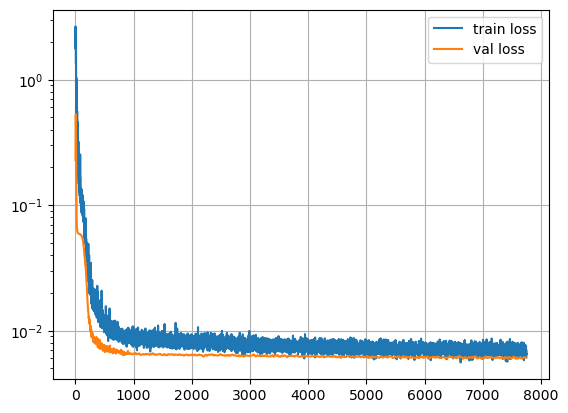

In [8]:
plt.plot(loss_history, label="train loss")
plt.plot(val_loss_history, label="val loss")
plt.legend()
plt.yscale("log")
plt.grid()

print(val_loss_history[-1])
# 0.0069615683

# 0.0078 ( mit 0.28 bei dropout, sonst so wie grad eingestellt)

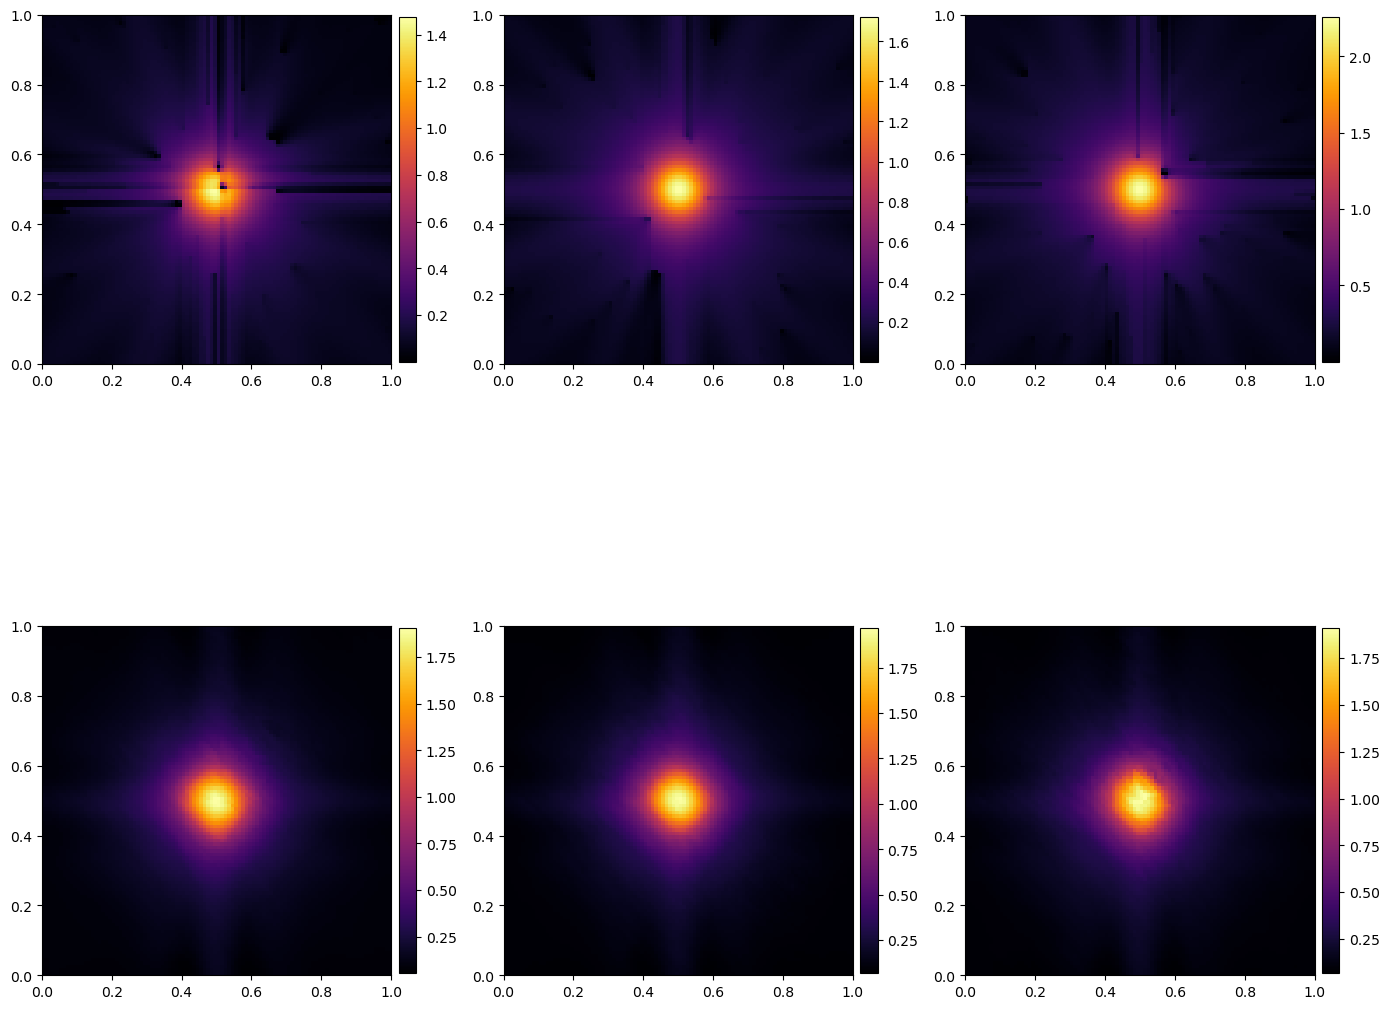

In [9]:
# make plots

# Define subplot grid
num_rows = 2
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 14))

# Flatten the axes array to easily iterate
axes = axes.ravel()

for i, ax in enumerate(axes):
    if i <= 2:
        #im = ax.imshow(jnp.log10(test_y[i, 0, :, :]), origin='lower', extent=[0, 1, 0, 1,], aspect='equal', cmap='inferno') #, vmax=1, vmin=-4)
        im = ax.imshow(test_out[i, 0, :, :], origin='lower', extent=[0, 1, 0, 1,], aspect='equal', cmap='inferno') #, vmax=1, vmin=-4)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    else:
        #im = ax.imshow(jnp.log10(fno2d(test_x[i-3, :, :, :])[0]), origin='lower', extent=[0, 1, 0, 1,], aspect='equal', cmap='inferno') #, vmax=1, vmin=-4)
        im = ax.imshow(fno2d(test_in[i-3, :, :, :], random.PRNGKey(2), deterministic=True )[0], origin='lower', extent=[0, 1, 0, 1,], aspect='equal', cmap='inferno') #, vmax=1, vmin=-4)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)  

plt.tight_layout()  
plt.show()

# try plotting on training data (not testdata) to check how good it gets there (without do and weight decay training reached error of 10^-4 I think)

In [10]:
# diagnostics 

In [11]:
def mean_squared_error(model, x, y, key, deterministic=True):
    y_pred = jax.vmap(model, in_axes=(0, None, None))(x, key, deterministic)
    loss = jnp.mean(jnp.square(y_pred - y), axis=0)
    return loss

def mean_relative_error(model, x, y, key, deterministic=True):
    y_pred = jax.vmap(model, in_axes=(0, None, None))(x, key, deterministic)
    loss = jnp.mean(jnp.abs(y_pred - y)/y, axis=0)  # is this formula correct?
    return loss



key = jax.random.PRNGKey(0)
loss_mse = mean_squared_error(fno2d, test_in, test_out, key).squeeze()
loss_relative = mean_relative_error(fno2d, test_in, test_out, key).squeeze()

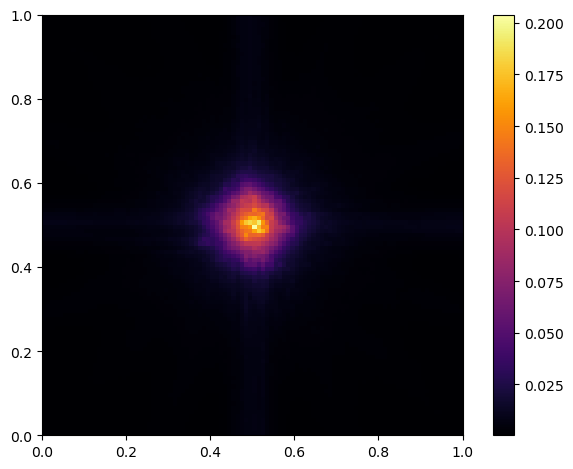

In [12]:
plt.imshow(loss_mse, origin='lower', extent=[0, 1, 0, 1,], aspect='equal', cmap='inferno')  # check if shape of loss_mse fits
plt.colorbar()  
plt.tight_layout()  
plt.show()

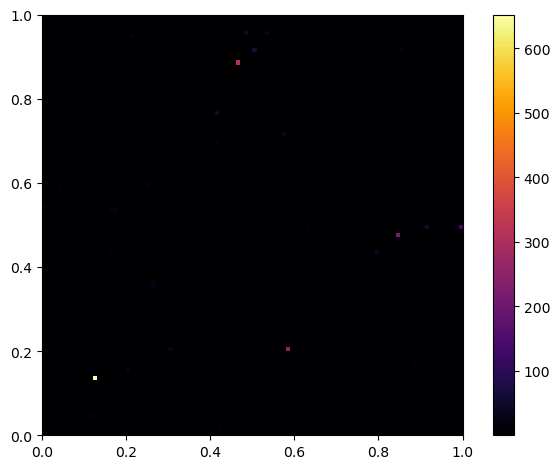

In [13]:
plt.imshow(loss_relative, origin='lower', extent=[0, 1, 0, 1,], aspect='equal', cmap='inferno')  # check if shape of loss_relative fits
plt.colorbar()

plt.tight_layout()  
plt.show()

In [14]:
# double check architecture

# further diagnostics?

# Prameters in new code, number of points per degree, stepsize, total number of steps